In [1]:
#Import required packages
import ee
import pandas as pd
import numpy as np
import geopandas as gpd
import geemap
import json
import requests
from shapely.geometry import Point
from functools import reduce
import geemap.foliumap as foliumap
from matplotlib import pyplot as plt

In [2]:
# User-defined Variables
my_cloud_project = 'ee-YourCloudProject' # your GEE cloud project ID
background_asset = 'conus_background' # name of your GEE background asset 

# Each NAS has a unique species ID that tells the database which taxa you want records from.
#Get species ID from https://nas.er.usgs.gov/api/v2/species 
#use ctrl f to search for your NAS. Change my_species_id to match
# zebra mussels = 5 ; emf = 237; ebt = 939; ssw = 1688
my_species_id = 237 

# Set Up geometry, background and import yearly covariate rasters.
MY_state_abbrev = 'MN' # change to your state of interest
MY_state = 'Minnesota' # change to your state of interest
MY_scale = 1000

In [3]:
ee.Authenticate() # You should already be authenticated from making your covariate rasters, but run just in case
# Leave the read-only box un-checked
# To force re-authentication run ee.Authenticate(force = True) instead 
ee.Initialize(project=my_cloud_project) # your GEE cloud project

In [4]:
# Get state geometry
conus_states = ee.FeatureCollection('TIGER/2018/States')
MY_geo = conus_states.filter(ee.Filter.equals('STUSPS', MY_state_abbrev)).geometry() 

# You should have uploaded the background shapefile by now.
background = ee.FeatureCollection("projects/" + my_cloud_project +"/assets/" + background_asset) # Change to the path where you stored the background csv
MY_background = background.filter(ee.Filter.eq('states', MY_state_abbrev))

## Import the yearly covariate rasters you made here. These are examples for MN. Change paths here to your gee assets.  
Image_1 = ee.Image("projects/" + my_cloud_project +"/assets/covariates_" + MY_state_abbrev + "_2003") 
Image_2 = ee.Image("projects/" + my_cloud_project +"/assets/covariates_" + MY_state_abbrev + "_2004")
Image_3 = ee.Image("projects/" + my_cloud_project +"/assets/covariates_" + MY_state_abbrev + "_2005") 
Image_4 = ee.Image("projects/" + my_cloud_project +"/assets/covariates_" + MY_state_abbrev + "_2006")
Image_5 = ee.Image("projects/" + my_cloud_project +"/assets/covariates_" + MY_state_abbrev + "_2007") 
Image_6 = ee.Image("projects/" + my_cloud_project +"/assets/covariates_" + MY_state_abbrev + "_2008")
Image_7 = ee.Image("projects/" + my_cloud_project +"/assets/covariates_" + MY_state_abbrev + "_2009") 
Image_8 = ee.Image("projects/" + my_cloud_project +"/assets/covariates_" + MY_state_abbrev + "_2010")
Image_9 = ee.Image("projects/" + my_cloud_project +"/assets/covariates_" + MY_state_abbrev + "_2011") 
Image_10 = ee.Image("projects/" + my_cloud_project +"/assets/covariates_" + MY_state_abbrev + "_2012")
Image_11 = ee.Image("projects/" + my_cloud_project +"/assets/covariates_" + MY_state_abbrev + "_2013") 
Image_12 = ee.Image("projects/" + my_cloud_project +"/assets/covariates_" + MY_state_abbrev + "_2014")
Image_13 = ee.Image("projects/" + my_cloud_project +"/assets/covariates_" + MY_state_abbrev + "_2015") 
Image_14 = ee.Image("projects/" + my_cloud_project +"/assets/covariates_" + MY_state_abbrev + "_2016")
Image_15 = ee.Image("projects/" + my_cloud_project +"/assets/covariates_" + MY_state_abbrev + "_2017") 
Image_16 = ee.Image("projects/" + my_cloud_project +"/assets/covariates_" + MY_state_abbrev + "_2018")
Image_17 = ee.Image("projects/" + my_cloud_project +"/assets/covariates_" + MY_state_abbrev + "_2019") 
Image_18 = ee.Image("projects/" + my_cloud_project +"/assets/covariates_" + MY_state_abbrev + "_2020")
Image_19 = ee.Image("projects/" + my_cloud_project +"/assets/covariates_" + MY_state_abbrev + "_2021") 


## If you want a different timeframe, remove images from within parentheses before creating ImageCollection.
my_env_data = ee.ImageCollection([Image_1, Image_2, Image_3, Image_4, Image_5, Image_6, Image_7, Image_8, Image_9, Image_10,
                                Image_11, Image_12, Image_13, Image_14, Image_15, Image_16, Image_17, Image_18, Image_19]).median()

In [5]:
## Currently, all environmental parameters from your covariate rasters will be used to build the model
## You can comment out parameters you don't want used to train your model by inserting # in front of the band name in this list.
parameter_selector = [
    'elevation', # for example, you might comment out elevation when using a model trained with MN data to project to ID.
    'Heat_Insolation_Load',
    'Topographic_Diversity',
    'gHM',
    'Max_LST_Annual',
    'Mean_GPP',
    'Max_NDVI',
    'Max_EVI', 
    'winter_totalPrecip', 
    'spring_totalPrecip',
    'summer_totalPrecip', 
    'fall_totalPrecip', 
    'Flashiness']
MY_collections = my_env_data.select(parameter_selector)

In [6]:
#Helper functions for importing/formatting data from NAS API
def _get_col_rename(df, dftype):
    """Returns a dictionary of columns to rename based on the dataframe and type('csv' or 'api')"""
# Build a dictionary of column renamings for use in pandas rename function
    renamed_columns = {}
    column_names = list(df.columns)
    lower_columns = [name.lower().replace(' ','').replace('_','') for name in column_names]
    for i in range(len(column_names)):
        renamed_columns[column_names[i]] = lower_columns[i]

    if dftype == 'csv':
        # build csv rename dictionary
        renamed_columns['museumcatno'] = 'museumcatnumber'
        renamed_columns['huc8number']  = 'huc8'
    elif dftype == 'api':
        # build api rename dictionary
        renamed_columns['key']              = 'specimennumber'
        renamed_columns['decimallatitude']  = 'latitude'
        renamed_columns['decimallongitude'] = 'longitude'
        renamed_columns['latlongsource']    = 'source'
        renamed_columns['latlongaccuracy']  = 'accuracy'
    else:
        raise ValueError(f"Dataframe type '{dftype}' invalid - Accepted inputs are 'csv' or 'api'")

    return renamed_columns

def _manage_cols(df, drop_list=[], name_dict={}):
    """Private method for dropping and renaming columns in a dataframe, as well as creating one standard table from two different forms."""

    for colname in drop_list:
        if colname not in df:
            raise ValueError(f"Can't drop column '{colname}' - '{colname}' does not exist in dataframe")
    for colname in list(name_dict.keys()):
        if colname not in df:
            raise ValueError(f"Can't rename '{colname}' to '{name_dict[colname]}' - '{colname}' does not exist in dataframe")
        if colname in drop_list:
            raise ValueError(f"Can't rename '{colname}' to '{name_dict[colname]}' - '{colname}' in drop_list")

    column_names = np.setdiff1d(list(df.columns), list(name_dict.keys()))
    lower_columns = [name.lower().replace(' ','').replace('_','') for name in column_names]
    for i in range(len(column_names)):
        name_dict[column_names[i]] = lower_columns[i]
    
    df = df.drop(drop_list, axis=1)
    df = df.rename(columns=name_dict)
    
    return df

URL_BASE = 'http://nas.er.usgs.gov/api/v2/'

def api_df(species_id, limit, api_key):
    """Returns a pandas dataframe containing records about a species from the NAS database using their API"""
    
    # Check for API key
    if api_key is not None:
        url_request = f"{URL_BASE}/occurrence/search?species_ID={species_id}&api_key={api_key}"
    else:
        url_request = f"{URL_BASE}/occurrence/search?species_ID={species_id}"
    
    # Get dataframe from API request
    request_json = requests.get(url_request, params={'limit':limit}).json()
    api_df = pd.json_normalize(request_json, 'results')
    api_df = _manage_cols(api_df)

    # Add columns that are in a CSV dataframe but not an API dataframe
    api_df['country']      = np.nan
    api_df['drainagename'] = np.nan

    # Rename columns
    renamed_columns = _get_col_rename(api_df, 'api')
    api_df = api_df.rename(columns=renamed_columns)

    # Reorder columns
    cols = list(api_df.columns)
    cols = cols[0:8] + cols[33:34] + cols[8:33] + cols[34:] # country
    cols = cols[0:16] + cols[34:] + cols[16:34] # drainagename
    api_df = api_df[cols]
    
    return api_df

In [7]:
#Get records by species ID from NAS database.
my_NAS = api_df(my_species_id, limit = 10000, api_key = {"speciesID": my_species_id})
## Grab just the columns we need for filtering the occurence records
my_data = my_NAS[["state", "latitude", "longitude", "year", "status", "accuracy"]]
## Filter the pandas dataframe to get only accurate presences for your state.
## If you are increasing the extent of your model, you can get NAS data for multiple states by replacing
# & (my_data['state'] == My_state) with & (my_data['state'].isin([MY_state, 'State_2_name'])
my_data = my_NAS[["state", "latitude", "longitude", "year", "status", "accuracy"]]
my_data_fltr = my_data[(my_data['status'] == 'established') & (my_data['accuracy'] == 'Accurate')
& (my_data['state'] == MY_state)] 
my_data_fixed = my_data_fltr.dropna()
#turn it into a geo datafrome
user_data_gdf = gpd.GeoDataFrame(
    my_data_fixed, geometry=gpd.points_from_xy(my_data_fixed.longitude, my_data_fixed.latitude))
#add Coordinate Reference System (CRS)
user_data_gdf.crs = "EPSG:4326"
#convert geopandas object into ee object
fc = geemap.geopandas_to_ee(user_data_gdf)
#add present property 
def addPresent (property):
    return property.set('Present', 1);
user_data = fc.map(addPresent)

In [8]:
# Train model with all data
training_data_all = user_data.merge(MY_background).filterBounds(MY_geo)

# split for training and testing with eDNA
training_points_all = MY_collections.reduceRegions(**{
                              'collection': training_data_all,
                              'reducer': ee.Reducer.mean(),
                              'crs': 'EPSG:4326',
                              'scale': MY_scale,
                              'tileScale': 16})
#Define Classifier and setup for MaxEnt Parameters 
classifier_all = ee.Classifier.amnhMaxent().train(**{
        'features': training_points_all,
        'classProperty': 'Present',
        'inputProperties': MY_collections.bandNames()
    })
    
MY_input_classified = MY_collections.classify(classifier_all);

In [9]:
## Train and test your model
## Run 10-fold cross validation to check model performance
newList = ee.List([])
results_df = []
importance_df = []
for x in range(10):
    data_split = user_data.randomColumn(seed= x)
    training_data = data_split.filter(ee.Filter.lte('random', 0.75)).merge(MY_background)
    testing_data = data_split.filter(ee.Filter.gt('random', 0.75))
            
# split for training and testing with eDNA
    training_points = MY_collections.reduceRegions(**{
                              'collection': training_data,
                              'reducer': ee.Reducer.mean(),
                              'crs': 'EPSG:4326',
                              'scale': MY_scale,
                              'tileScale': 16})
#Define Classifier and setup for MaxEnt Parameters 
    classifier = ee.Classifier.amnhMaxent().train(**{
        'features': training_points,
        'classProperty': 'Present',
        'inputProperties': MY_collections.bandNames()
    })
    
    input_classified = MY_collections.classify(classifier);

    diff = (MY_input_classified.select('probability').subtract(input_classified.select('probability'))).abs()
    newList = newList.add(diff)
    
    testing_points = MY_input_classified.reduceRegions(**{
                              'collection': testing_data,
                              'reducer': ee.Reducer.mean(),
                              'crs': 'EPSG:4326',
                              'scale': MY_scale,
                              'tileScale': 16})
    

#Select get the predictions from the testing locations
    false_neg_testing = testing_points.select('probability');
    my_false_negs =  false_neg_testing.filter(ee.Filter.lessThan('probability', 0.30)).size();
    my_true_pos = false_neg_testing.filter(ee.Filter.greaterThan('probability', 0.70)).size();
    my_fn_rate =  my_false_negs.divide(my_false_negs.add(my_true_pos));
    results = ee.List([my_fn_rate]).getInfo()
    classifier_results = classifier.explain();
    importance = classifier_results.get('Contributions')
    imp = importance.getInfo()
    results_df.append(results)
    importance_df.append(imp)
    uncertainty = (ee.ImageCollection.fromImages(newList)).mean()

Text(0.5, 1.0, 'Cross Validation Results')

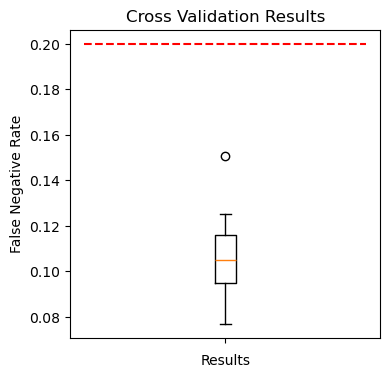

In [10]:
## Plot false negative rates from cross validation
all_data = pd.DataFrame(results_df)
fig, ax1 = plt.subplots(figsize=(4, 4))
labels = ['All Data']
# rectangular box plot
bplot1 = ax1.boxplot(all_data, vert=True) 
plt.hlines(0.2, xmin=0, xmax=2, color='r', linestyles='--')
ax1.set_ylabel('False Negative Rate')
ax1.set_xticklabels("")
ax1.set_xlabel('Results')
ax1.set_title('Cross Validation Results')

In [11]:
# Use the Surface Water Occurence Band to mask the prediction so only pixels with water are visible
water_pixels = my_env_data.select('SurfaceWaterOccurrence')
waterMask = water_pixels.gte(0.000001)

prediction_masked = MY_input_classified.mask(waterMask)
uncertainty_masked = uncertainty.mask(waterMask)
# Apply smoothing function
smoother = ee.Kernel.square(**{
    'radius': 8,
    'magnitude': 1
})
pred_smoothed = prediction_masked.convolve(smoother)
unc_smoothed = uncertainty_masked.convolve(smoother)
#Create color paramaters and map classified image
Probability_PARAMS = {"opacity":1,"bands":["probability"],
"palette":["2b83ba","6ab0af","abdda4","cdebaf","ffffbf", "fed790", "fdae61", "d7191c", "921113"]}
Map = foliumap.Map(center=[45,-95], zoom=6)
Map.add_colorbar(Probability_PARAMS)
Map.addLayer(unc_smoothed, Probability_PARAMS, 'Uncertainty')
Map.addLayer(pred_smoothed, Probability_PARAMS, 'Habitat Suitability')
Map

In [12]:
no_heat = MY_collections.select(['Topographic_Diversity', 'gHM', 'Max_LST_Annual',
  'Mean_GPP', 'Max_NDVI', 'winter_totalPrecip', 'summer_totalPrecip', 'Flashiness', 'elevation']);
no_topo = MY_collections.select(['Heat_Insolation_Load', 'gHM', 'Max_LST_Annual',
  'Mean_GPP', 'Max_NDVI', 'winter_totalPrecip', 'summer_totalPrecip', 'Flashiness', 'elevation']);
no_ghm = MY_collections.select(['Heat_Insolation_Load', 'Topographic_Diversity', 'Max_LST_Annual',
  'Mean_GPP', 'Max_NDVI', 'winter_totalPrecip', 'summer_totalPrecip', 'Flashiness', 'elevation']);
no_lst = MY_collections.select(['Heat_Insolation_Load', 'Topographic_Diversity', 'gHM', 
  'Mean_GPP', 'Max_NDVI', 'winter_totalPrecip', 'summer_totalPrecip', 'Flashiness', 'elevation']);
no_gpp = MY_collections.select(['Heat_Insolation_Load', 'Topographic_Diversity', 'gHM', 'Max_LST_Annual',
  'Max_NDVI', 'winter_totalPrecip', 'summer_totalPrecip', 'Flashiness', 'elevation']);
no_ndvi = MY_collections.select(['Heat_Insolation_Load', 'Topographic_Diversity', 'gHM', 'Max_LST_Annual',
  'Mean_GPP', 'winter_totalPrecip', 'summer_totalPrecip', 'Flashiness', 'elevation']);
no_w_precip = MY_collections.select(['Heat_Insolation_Load', 'Topographic_Diversity', 'gHM', 'Max_LST_Annual',
  'Mean_GPP', 'Max_NDVI','summer_totalPrecip', 'Flashiness', 'elevation']);
no_s_precip = MY_collections.select(['Heat_Insolation_Load', 'Topographic_Diversity', 'gHM', 'Max_LST_Annual',
  'Mean_GPP', 'Max_NDVI', 'winter_totalPrecip','Flashiness', 'elevation']);
no_flash = MY_collections.select(['Heat_Insolation_Load', 'Topographic_Diversity', 'gHM', 'Max_LST_Annual',
  'Mean_GPP', 'Max_NDVI', 'winter_totalPrecip', 'summer_totalPrecip', 'elevation']);
no_elev = MY_collections.select(['Heat_Insolation_Load', 'Topographic_Diversity', 'gHM', 'Max_LST_Annual',
  'Mean_GPP', 'Max_NDVI', 'winter_totalPrecip', 'summer_totalPrecip', 'Flashiness']);

In [13]:
jk_data = [no_heat, no_topo, no_ghm, no_lst, no_gpp, no_ndvi, no_w_precip,
                             no_s_precip, no_flash, no_elev]
newList2 = ee.Image()

for x in jk_data:
      
# split for training and testing with eDNA
    training_points = x.reduceRegions(**{
                              'collection': training_data_all,
                              'reducer': ee.Reducer.mean(),
                              'crs': 'EPSG:4326',
                              'scale': MY_scale,
                              'tileScale': 16})
#Define Classifier and setup for MaxEnt Parameters 
    classifier = ee.Classifier.amnhMaxent().train(**{
        'features': training_points,
        'classProperty': 'Present',
        'inputProperties': x.bandNames()
    })
    
    MY_input_classified = x.classify(classifier);

    diff2 = (MY_input_classified.select('probability').subtract(input_classified.select('probability'))).abs()
    newList2 = newList2.addBands(diff2)

In [14]:
jk_df = newList2.select('probability.*')
water = ee.FeatureCollection('projects/ee-shopvac18/assets/buffered_up_miss_lrg_water2')
my_water = water.filterBounds(MY_geo)
stats = jk_df.reduceRegions(
      collection =  my_water,
      reducer = ee.Reducer.median(),
      scale = MY_scale,  
    );
stat_df = ee.data.computeFeatures({
    'expression': stats,
    'fileFormat': 'GEOPANDAS_GEODATAFRAME'
})

<Axes: >

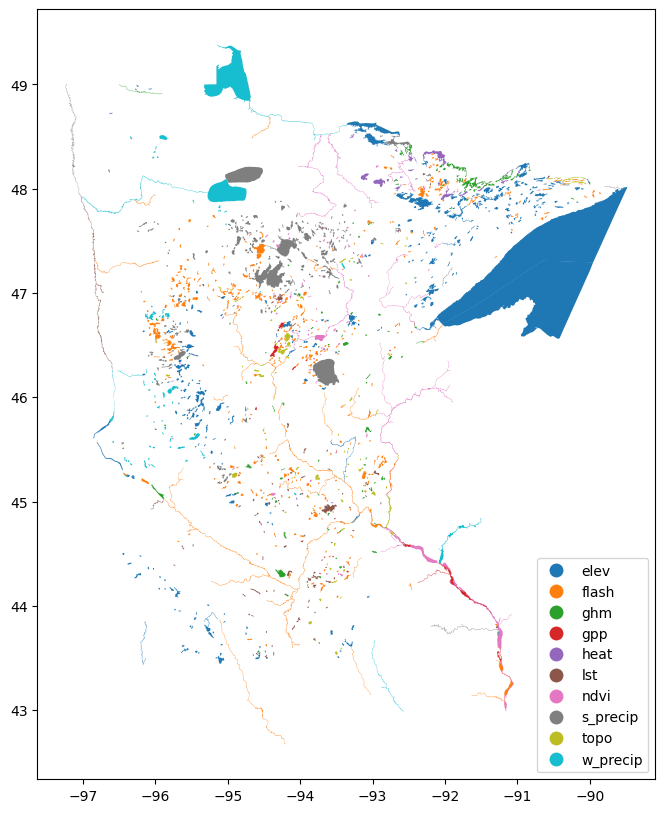

In [15]:
my_stats = stat_df.rename(columns={'probability': "heat", 'probability_1' : "topo", 'probability_2' : "ghm", 'probability_3' : "lst",
                       'probability_4' : "gpp", 'probability_5' : "ndvi", 'probability_6' : "w_precip", 'probability_7' : "s_precip",
                       'probability_8' : "flash", 'probability_9' : "elev"})
max_column = my_stats[['heat', 'topo', 'gpp', 'lst', 'ghm', 's_precip', 'elev', 'w_precip', 'ndvi', 'flash']]
df_array = np.array(max_column)
max_column_index = np.argmax(df_array, axis=1)
top_param = pd.DataFrame(max_column.columns[max_column_index])
param_df_2 = top_param.rename(columns={0: "Top_Param"})
top_params_df = pd.merge(stat_df, param_df_2, left_index=True, right_index=True).set_crs("EPSG:4326")
df = top_params_df[['geometry', 'Top_Param']]
df.plot(column="Top_Param", figsize=(10, 10), legend=True, legend_kwds={'loc': 'lower right'})

In [ ]:
#Check parameter contributions/importance across all pixels.
imp_df = pd.DataFrame(importance_df)
imp_df_mean = pd.DataFrame(imp_df.mean(axis=0))
imp_df_se = pd.DataFrame(imp_df.sem(axis=0))
imp_results = imp_df_mean.merge(imp_df_se, left_index=True, right_index=True).reset_index()
imp_formatted = imp_results.rename(columns={"index": "Parameter", "0_x": "Contribution", "0_y": "std_er"})
fig, ax = plt.subplots(figsize=(9, 4))
params = np.array(imp_formatted['Parameter'])
importance = np.array(imp_formatted['Contribution'])
err_bars = np.array(imp_formatted['std_er'])
ax.bar(params, importance)
plt.errorbar(params, importance, yerr=err_bars, fmt=".", color="r")
plt.xticks(rotation = 75)
ax.set_ylabel('Change in AUC when parameter is removed')
ax.set_title('Parameter Importance')
plt.show()

In [ ]:
#Export your heatmap to your GEE assets
task = ee.batch.Export.image.toAsset(
    image = MY_input_classified,
    description='my_heatmap',
    assetId="projects/" + my_cloud_project +"/assets/my_heatmap",  # <> modify these
    region=MY_geo,
    scale=MY_scale)
task.start()

In [ ]:
#Export your heatmap to your GEE assets
task = ee.batch.Export.image.toAsset(
    image = uncertainty,
    description='my_uncertainty_map',
    assetId="projects/" + my_cloud_project +"/assets/my_uncertainty_map",  # <> modify these
    region=MY_geo,
    scale=MY_scale)
task.start()

In [ ]:
task = ee.batch.Export.table.toAsset(
    collection = df,
    description='top_params',
    assetId="projects/" + my_cloud_project +"/assets/top_params")
task.start()

In [ ]:
task = ee.batch.Export.table.toAsset(
    collection = user_data,
    description='NAS Records',
    assetId="projects/" + my_cloud_project +"/assets/my_nas_records")
task.start()